In [1]:
#Import required libraries
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
import warnings
warnings.filterwarnings('ignore')
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Full Corpus
full_corpus_df = pd.read_csv('../data/arab_observer_corpus_cleaned.csv')
#Distinguish origin of data 
full_corpus_df.type[full_corpus_df.type == 'hathi_trust'] = 'HathiTrust Volumes'
full_corpus_df.type[full_corpus_df.type == 'collected_issues'] = 'Collected Issues'
full_corpus_df.sort_values(by=['datetime', 'binned', 'page_number'], inplace=True)
#Order datasets temporally
full_corpus_df['date_bin'] = full_corpus_df.date.astype(str)+'_'+full_corpus_df.binned.astype(str)
full_corpus_df['date_page'] = full_corpus_df.date.astype(str)+'_'+full_corpus_df.page_number.astype(str)
full_corpus_df['datetime'] = pd.to_datetime(full_corpus_df['date'], format='%Y-%B-%d', errors='coerce')
full_corpus_dates = full_corpus_df.date.unique().tolist()

In [3]:
ao_1960 = full_corpus_df.query('date.str.contains("1960")')

In [4]:
ao_1960 = full_corpus_df.loc[full_corpus_df.datetime < '1960-07-01']

In [5]:
ao_1960.dropna(subset=['cleaned_spacy_text'], inplace=True)

In [6]:
arab_review_df = pd.read_csv('../data/Arab_Review_1960_1963_volumes_processed.csv')
arab_review_df.dates.unique()
arab_review_df['page_date'] = arab_review_df.dates.astype(str)+'_'+arab_review_df.page.astype(str)
arab_review_df['type'] = 'arab_review'

In [7]:
hundo = arab_review_df[0:150]
hundo.dropna(subset=['cleaned_spacy_text'], inplace=True)

In [8]:
def create_tfidf_model(df, ngr, max_terms, maxdf=1.0):
    
    vectorizer = TfidfVectorizer(ngram_range=ngr, max_df=maxdf)
    docs = vectorizer.fit_transform(df.cleaned_spacy_text.values.astype('U'))
    features = vectorizer.get_feature_names()
    count = np.squeeze(np.asarray(docs.sum(axis=0)))
    sorted_count = count.argsort()[::-1]
    dist_df =pd.DataFrame({'freq': count, 'term':np.array(features)})
    dist_df['type'] = model_identifier
    dist_df['freqz'] = dist_df[['freq']].apply(lambda x: (x-x.min())/(x.max()-x.min())+ 0.000001)
    dist_df.sort_values(by=['freqz'], inplace=True, ascending=False)
    df2 = pd.DataFrame(docs.toarray(), columns = features)
    df3 = df2.T
    df3['term'] = df3.index
    df3.reset_index(inplace=True, drop=True)
    df_melted = df3.melt('term', value_name='value', var_name='page_number')

    df_merged = dist_df.merge(df_melted, on='term', how='inner')
    df_terms = df_merged.copy()
    df_terms = df_terms.drop_duplicates('term')
    
    return df_terms[0:max_terms], df_merged

In [9]:
def get_topics(df, ngram, num_topics, num_top_words, max_terms, maxdf=1.0):
    tfidf_model = TfidfVectorizer(ngram_range=ngram, lowercase=False, max_df=maxdf)
    features = tfidf_model.fit_transform(df.cleaned_spacy_text.tolist())
    feature_terms = tfidf_model.get_feature_names()
    count = np.squeeze(np.asarray(features.sum(axis=0)))
    sorted_count = count.argsort()[::-1]
    dist_df =pd.DataFrame({'freq': count, 'term':np.array(feature_terms)})
    dist_df['freqz'] = dist_df[['freq']].apply(lambda x: (x-x.min())/(x.max()-x.min())+ 0.000001)
    dist_df.sort_values(by=['freqz'], inplace=True, ascending=False)
    df2 = pd.DataFrame(features.toarray(), columns = feature_terms)
    df3 = df2.T
    df3['term'] = df3.index
    df3.reset_index(inplace=True, drop=True)
    df_melted = df3.melt('term', value_name='value', var_name='page_number')
    
    df_merged = dist_df.merge(df_melted, on='term', how='inner')
    df_terms = df_merged.copy()
    df_terms = df_terms.drop_duplicates('term')
    
    
    features_dtm = features.toarray()

    clf = decomposition.NMF(n_components=num_topics, random_state=1)
    doctopic = clf.fit_transform(features_dtm)
    vocab = np.array(tfidf_model.get_feature_names())
    topic_words = []
    for topic in clf.components_:
        word_idx = np.argsort(topic)[::-1][0:num_top_words]
        topic_words.append([vocab[i] for i in word_idx])
    docnames = [str(i) for i in range(doctopic.shape[0])]
    topicnames = [ " ".join(topic_words[i]) for i in range(len(clf.components_))]
    df_document_topic = pd.DataFrame(doctopic, columns=topicnames, index=docnames)
    return df_terms[0:max_terms], df_document_topic

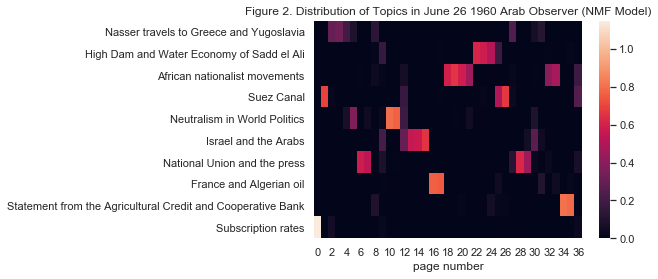

In [11]:
ao_tops, ao_docs = get_topics(ao_1960, (1,2), 10, 5, 20)
# f, ax = plt.subplots(figsize=(8, 16))
ao_docs.rename(columns={'greek greece president nasser abdel nasser':'Nasser travels to Greece and Yugoslavia', 'dam river water metres construction':'High Dam and Water Economy of Sadd el Ali', 'african africa political nationalist africans': 'African nationalist movements', 'canal suez canal suez eighth programme':'Suez Canal', 'powers states small neutralist big powers':'Neutralism in World Politics', 'israel us replied asked jewish': 'Israel and the Arabs', 'press union newspapers al public': 'National Union and the press', 'oil gas hassi algeria massaoud': 'France and Algerian oil', 'bank le credit tons year': 'Statement from the Agricultural Credit and Cooperative Bank', 'aug significance fils poin pia poin brit': 'Subscription rates'}, inplace=True)
ax = sns.heatmap(ao_docs.transpose())
ax.set_title('Figure 2. Distribution of Topics in June 26 1960 Arab Observer (NMF Model)')
ax.set_ylabel('')
ax.set_xlabel('page number')
ax.figure.savefig('june261960_ao_topics.png',dpi=400, bbox_inches = "tight")

In [200]:
cols = ao_docs.columns.tolist()
for i in range(0, len(cols)):
    print(i, cols[i])

0 greek greece president nasser abdel nasser abdel uar gamal abdel gamal talks visit president gamal arab press tito world said peace two tanashi
1 dam river water metres construction million high el aali aali project sadd high dam power site storage sadd el lake economy el capacity
2 african africa political nationalist africans movements british continent world independence french arab imperialism commission african nationalist people colonial government imperial spirit
3 canal suez canal suez eighth programme km metres section modified eighth programme widening wet cubic metres cubic million million cubic dredging deepening wet cross modified eighth
4 powers states small neutralist big powers big small powers east west west nations neutralist states united nations east summit would soviet soviet union assembly international world
5 israel us replied asked jewish arabs homes picture said israeli arab plane jews land ministry ben gurion ben gurion nazareth voice
6 press union newspape

In [156]:
ao_docs.rename(columns={'greek greece president nasser abdel nasser':'Nasser travels to Greece and Yugoslavia', 'dam river water metres construction':'High Dam and Water Economy of Sadd el Ali', 'african africa political nationalist africans': 'African nationalist movements', 'canal suez canal suez eighth programme':'Suez Canal', 'powers states small neutralist big powers':'Neutralism in World Politics', 'israel us replied asked jewish': 'Israel and Arabs', 'press union newspapers al public': 'National Union elections', 'oil gas hassi algeria massaoud': 'France and Algerian oil', 'bank le credit tons year': 'Statement from the Agricultural Credit and Cooperative Bank', 'aug significance fils poin pia poin brit': 'Subscription rates'})

Index(['greek greece president nasser abdel nasser',
       'dam river water metres construction',
       'african africa political nationalist africans',
       'canal suez canal suez eighth programme',
       'powers states small neutralist big powers',
       'israel us replied asked jewish', 'press union newspapers al public',
       'oil gas hassi algeria massaoud', 'bank le credit tons year',
       'aug significance fils poin pia poin brit'],
      dtype='object')

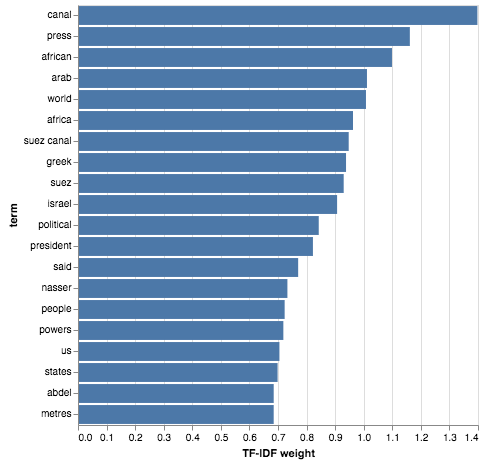

In [146]:
alt.Chart(ao_tops).mark_bar().encode(
    x=alt.X('freq:Q', axis=alt.Axis(title='TF-IDF weight')),
    y=alt.Y(
        'term:N',
         sort=alt.EncodingSortField(
            field="freq",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        )
    )

).properties( )

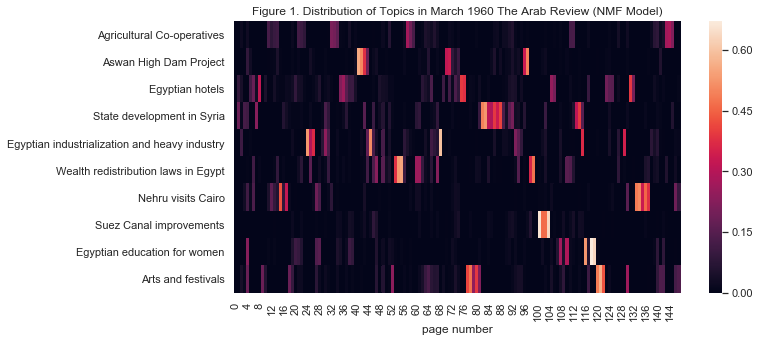

In [204]:
hundo_tops, hundo_docs = get_topics(hundo, (1,1), 10, 5, 20)
# # print(hundo_tops)
f, ax = plt.subplots(figsize=(10, 5))
hundo_docs.rename(columns={'reform cooperative agrarian cooperatives production': 'Agricultural Co-operatives', 'dam high power aswan project': 'Aswan High Dam Project','soliman sheikh review el hotel': 'Egyptian hotels', 'latakia northern region damascus acres': 'State development in Syria', 'president nasser pakistan india indian': 'Nehru visits Cairo', 'tons steel production iron year': 'Egyptian industrialization and heavy industry',  'le insurance economic savings capital': 'Wealth redistribution laws in Egypt', 'canal suez authority project widening': 'Suez Canal improvements', 'women schools woman university education': 'Egyptian education for women', 'ballet programme house reda art':'Arts and festivals'}, inplace=True)
ax = sns.heatmap(hundo_docs.transpose())
ax.set_title('Figure 1. Distribution of Topics in March 1960 The Arab Review (NMF Model)')
ax.set_ylabel('')
ax.set_xlabel('page number')
ax.figure.savefig('march60_ar_topics.png', dpi=400, bbox_inches = "tight")
# # figure = svm.get_figure()    
# # figure.savefig('svm_conf.png', dpi=400)

In [202]:
cols = hundo_docs.columns.tolist()
for i in range(0, len(cols)):
    print(i, cols[i])

0 reform cooperative agrarian cooperatives production centres agricultural land farmers society bahi din al also societies new livestock year landowners increase
1 dam high power aswan project metres produce flow temple water two nile completed stage monuments egypt proposed construction kwh per
2 soliman sheikh review el hotel uar cairo arab one clerk new seen old years day egypt mules chief whose would
3 latakia northern region damascus acres million kw cost kms areas land port new railways generate project roads projects development need
4 tons steel production iron year million risen increased industries machines mill petroleum oil nitrate ore heavy annually crude refinery work
5 le insurance economic savings capital workers security national republic organisation investment companies policy arab social law united million income regions
6 president nasser pakistan india indian friendly tour parliament arrival greeting abdul celebrating addresses gamal rather uar leaders talks peace

In [187]:
hundo_docs.rename(columns={'reform cooperative agrarian cooperatives production': 'Agricultural Co-operatives', 'dam high power aswan project': 'Aswan High Dam Project','soliman sheikh review el hotel': 'Egyptian hotels', 'latakia northern region damascus acres': 'State development in Syria', 'president nasser pakistan india indian': 'Nehru visits Cairo', 'tons steel production iron year': 'Egyptian industrialization and heavy industry',  'le insurance economic savings capital': 'Wealth redistribution laws in Egypt', 'canal suez authority project widening': 'Suez Canal improvements', 'women schools woman university education': 'Egyptian education for women', 'ballet programme house reda art':'Arts and festivals'})

,Agricultural Co-operatives,Aswan High Dam Project,Egyptian hotels,State development in Syria,Egyptian industrialization and heavy industry,Wealth redistribution laws in Egypt,Nehru visits Cairo,Suez Canal improvements,Egyptian education for women,Arts and festivals
0,0.000000,0.000000,0.000000,0.000000,0.000000,3.546211e-55,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.093747,0.184817,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2,0.022615,0.000000,0.043791,0.015113,0.105113,0.000000e+00,0.000000,0.000000,0.000000,0.040231
3,0.000000,0.000000,0.000000,0.121664,0.000000,0.000000e+00,0.029584,0.000000,0.000000,0.015207
4,0.026358,0.087931,0.000000,0.111828,0.000000,6.221934e-03,0.110657,0.000000,0.228212,0.183276
5,0.000000,0.029732,0.116826,0.000000,0.009454,0.000000e+00,0.017329,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.180765,0.000000,0.000000,1.129522e-01,0.132910,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.032010,0.230645,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.320662,0.000000,0.000000,1.107117e-02,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.185856


In [6]:
dist = euclidean_distances(features_dtm)
cos = 1- cosine_similarity(features_dtm)
norms = np.sqrt(np.sum(features_dtm * features_dtm, axis=1, keepdims=True))
dtm_normed = features_dtm / norms
sim = np.dot(dtm_normed, dtm_normed.T)
sim[1, 3]

0.0

In [80]:

num_topics = 5

clf = decomposition.NMF(n_components=num_topics, random_state=1)
doctopic = clf.fit_transform(features_dtm)

In [81]:
num_top_words = 15

In [82]:
vocab = np.array(tfidf_model.get_feature_names())

In [83]:
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])
topic_words

[['greek',
  'greece',
  'press',
  'president',
  'abdel nasser',
  'nasser',
  'abdel',
  'gamal abdel',
  'gamal',
  'uar',
  'visit',
  'arab',
  'president gamal',
  'talks',
  'sake'],
 ['dam',
  'bank',
  'water',
  'river',
  'metres',
  'oil',
  'million',
  'tons',
  'gas',
  'construction',
  'total',
  'le',
  'project',
  'high',
  'storage'],
 ['african',
  'africa',
  'political',
  'nationalist',
  'africans',
  'british',
  'movements',
  'french',
  'world',
  'continent',
  'independence',
  'people',
  'arab',
  'imperialism',
  'commission'],
 ['canal',
  'suez canal',
  'suez',
  'eighth',
  'programme',
  'km',
  'metres',
  'section',
  'modified',
  'eighth programme',
  'widening',
  'wet',
  'cubic metres',
  'cubic',
  'million'],
 ['israel',
  'powers',
  'states',
  'small',
  'us',
  'said',
  'neutralist',
  'israeli',
  'would',
  'replied',
  'big powers',
  'arabs',
  'big',
  'asked',
  'international']]

In [38]:
temp_df = pd.DataFrame()
for n in range(doctopic.shape[0]):
    
    topic_most_pr = doctopic[n].argmax()
    
    word_idx = np.argsort(clf.components_[topic_most_pr])[::-1][0:num_top_words]
    topic_words = []
#     [print(vocab[i]) for i in word_idx if vocab[i] == 'congo']
    topic_words.append([vocab[i] for i in word_idx])
    if 'congo'in topic_words[0]:
        print("doc: {} topic: {}\n value: {}".format(n,topic_most_pr, df_document_topic.iat[n,topic_most_pr]))
#     for i in word_idx:
#         df = pd.DataFrame({'term': vocab[i], 'doc': [n], 'topic': [topic_most_pr]})
#         print(df)
#         temp_df = temp_df.append(df, ignore_index=True)

In [103]:
docnames = [str(i) for i in range(doctopic.shape[0])]
topicnames = [ " ".join(topic_words[i]) for i in range(len(clf.components_))]

In [104]:
topicnames

['greek greece press president abdel nasser nasser abdel gamal abdel gamal uar visit arab president gamal talks sake',
 'dam bank water river metres oil million tons gas construction total le project high storage',
 'african africa political nationalist africans british movements french world continent independence people arab imperialism commission',
 'canal suez canal suez eighth programme km metres section modified eighth programme widening wet cubic metres cubic million',
 'israel powers states small us said neutralist israeli would replied big powers arabs big asked international']

In [105]:
df_document_topic = pd.DataFrame(doctopic, columns=topicnames, index=docnames)

In [106]:
df_document_topic

,greek greece press president abdel nasser nasser abdel gamal abdel gamal uar visit arab president gamal talks sake,dam bank water river metres oil million tons gas construction total le project high storage,african africa political nationalist africans british movements french world continent independence people arab imperialism commission,canal suez canal suez eighth programme km metres section modified eighth programme widening wet cubic metres cubic million,israel powers states small us said neutralist israeli would replied big powers arabs big asked international
0,0.116759,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.731421,0.000000
2,0.411116,0.000000,0.000000,0.024717,0.000000
3,0.444431,0.000000,0.000000,0.000000,0.000000
4,0.245557,0.000000,0.000000,0.000000,0.075081
5,0.110431,0.000000,0.000000,0.000000,0.302366
6,0.082281,0.004992,0.242257,0.000991,0.002921
7,0.069090,0.010189,0.154416,0.000000,0.133304
8,0.191208,0.058885,0.014207,0.000000,0.008568
9,0.002385,0.156260,0.004609,0.000000,0.257176


In [184]:
congo_words = ['congo',
  'belgian',
  'katanga',
  'belgium',
  'tshombe',
  'forces',
  'lumumba',
  'province',
  'independence',
  'united',
  'nations',
  'united nations',
  'hammarskjoeld',
  'african',
  'would',
  'country',
  'un',
  'troops',
  'mr',
  'security']

In [41]:
df_document_topic.set_index('doc', inplace=True)

KeyError: 'doc'

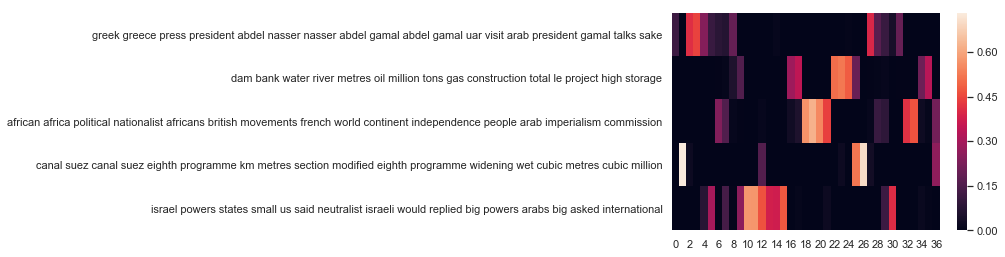

In [107]:
# sns.palplot(sns.color_palette('colorblind'))
ax = sns.heatmap(df_document_topic.transpose())

In [43]:

df_document_topic['doc'] = df_document_topic.index
df_document_topic.reset_index(inplace=True, drop=True)
df_document_topic_melted = df_document_topic.melt('doc', value_name='value_topic', var_name='topic')


docs = df_document_topic_melted.loc[df_document_topic_melted.value_topic > 0]
docs.sort_values(by=['topic', 'value_topic'], ascending=[True, False], inplace=True)
docs = docs.groupby('topic').head(num_top_words).reset_index()

,0,1,2,3,4,doc
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,False,False
6,False,False,False,False,False,False
7,False,False,False,False,False,False
8,False,False,False,False,False,False
9,False,False,False,False,False,False


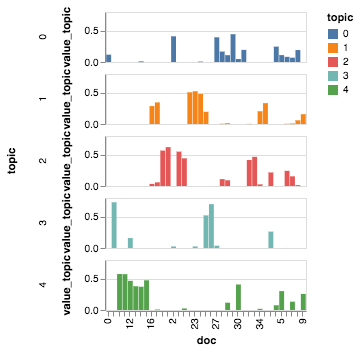

In [74]:
alt.Chart(docs).mark_bar().encode(
    x='doc:O',
    y=alt.Y('value_topic:Q'),
    color='topic:N',
    
    row='topic:N',
).properties(
    height=50,
    width=200
)

In [44]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(clf.components_)

# Assign Column and Index
df_topic_keywords.columns = vocab
df_topic_keywords.index = topicnames

In [45]:
df3 = df_topic_keywords.T
df3['term'] = df3.index
df3.reset_index(inplace=True, drop=True)
df_melted = df3.melt('term', value_name='value_term', var_name='topic')

In [46]:
df_congo = df_melted.loc[df_melted.term.isin(congo_words) == True]
df_congo = df_congo[['term', 'topic', 'value_term']]


dc = df_congo.pivot('term', 'topic', 'value_term')
sns.color_palette("husl")
ax = sns.heatmap(dc, cmap="YlGnBu")

NameError: name 'congo_words' is not defined

In [196]:
df_congo

,term,topic,value_term
1533,african,0,0.000000
6699,belgian,0,0.000000
6741,belgium,0,0.000000
12047,congo,0,0.006163
13667,country,0,0.136746
23103,forces,0,0.014221
26326,hammarskjoeld,0,0.000970
28835,independence,0,0.022988
31671,katanga,0,0.000000
34562,lumumba,0,0.000000


In [123]:
# df_melted = df_melted.loc[df_melted.value_term > 0]
df_melted.sort_values(by=['topic', 'value_term'], ascending=[True, False], inplace=True)
terms = df_melted.groupby('topic').head(num_top_words).reset_index()
# terms.set_index('term', inplace=True)
# terms.reset_index(inplace=True, drop=True)

In [124]:
terms = terms[['term', 'topic', 'value_term']]

In [125]:
terms = terms.pivot('term', 'topic', 'value_term')
terms = terms.fillna(0)

topic,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
term,,,,,,,,,,
abdel,0.183222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
abdel nasser,0.157032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
africa,0.000000,0.000000,0.000000,0.000000,0.000000,0.432159,0.000000,0.000000,0.000000,0.000000
african,0.000000,0.000000,0.000000,0.000000,0.120263,0.496732,0.000000,0.000000,0.000000,0.000000
african affairs,0.000000,0.199576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
african states,0.000000,0.000000,0.000000,0.000000,0.000000,0.085554,0.000000,0.000000,0.000000,0.000000
africans,0.000000,0.215360,0.000000,0.000000,0.000000,0.129205,0.000000,0.000000,0.000000,0.000000
africans south,0.000000,0.192684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
agents,0.000000,0.000000,0.000000,0.076058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


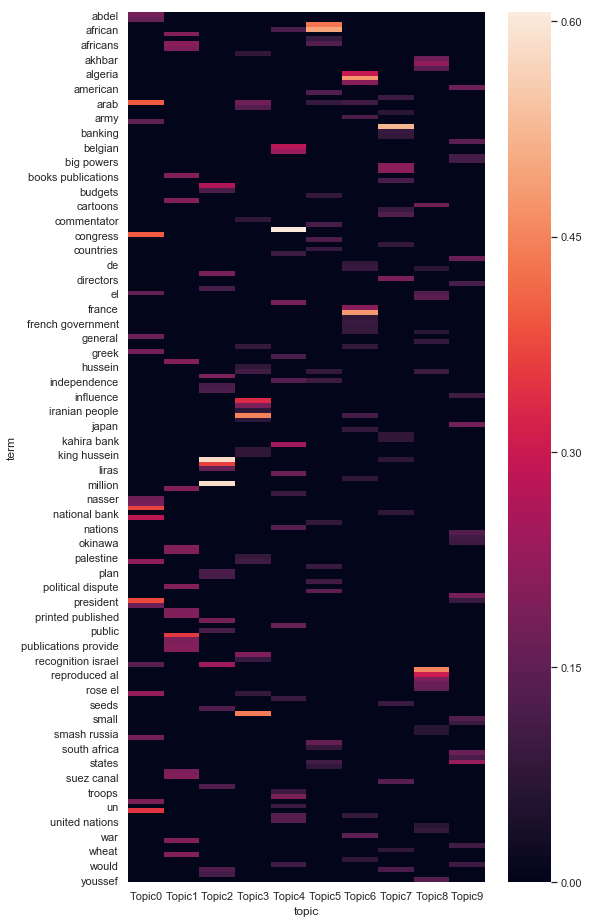

In [131]:
f, ax = plt.subplots(figsize=(8, 16))
ax = sns.heatmap(terms)

In [96]:
tm = terms.merge(docs, on=['topic'])

def print_rows(rows):
    print(rows)

# tm.groupby(['doc', 'topic'])['term'].apply(print_rows)
tm

,index_x,term,topic,value_term,index_y,doc,value_topic
0,12217,congress,Topic0,0.396870,146,146,0.210732
1,12217,congress,Topic0,0.396870,73,73,0.177900
2,12217,congress,Topic0,0.396870,142,142,0.173422
3,12217,congress,Topic0,0.396870,112,112,0.168510
4,12217,congress,Topic0,0.396870,132,132,0.166509
5,12217,congress,Topic0,0.396870,111,111,0.150467
6,12217,congress,Topic0,0.396870,144,144,0.150359
7,12217,congress,Topic0,0.396870,145,145,0.148212
8,12217,congress,Topic0,0.396870,108,108,0.143445
9,12217,congress,Topic0,0.396870,133,133,0.142117


In [32]:
# model = decomposition.NMF(init=self.init_strategy, n_components=k, max_iter=self.max_iters, random_state = self.random_seed)
# 		self.W = model.fit_transform(X)
# 		self.H = model.components_	
        
# top_indices = np.argsort( self.H[topic_index,:] )[::-1]
# 		# truncate if necessary
# 		if top < 1 or top > len(top_indices):
# 			return top_indices
# 		return top_indices[0:top]

# 	def generate_partition( self ):
# 		if self.W is None:
# 			raise ValueError("No results for previous run available")
# 		return np.argmax( self.W, axis = 1 ).flatten().tolist()	
# def generate_doc_rankings( W ):
# 	'''
# 	Rank document indices, based on values in a W factor matrix produced by NMF.
# 	'''
# 	doc_rankings = []
# 	k = W.shape[1]
# 	for topic_index in range(k):
# 		w = np.array( W[:,topic_index] )
# 		top_indices = np.argsort(w)[::-1]
# 		doc_rankings.append(top_indices)
# 	return doc_rankings

notes:
- show topics over time by page
- look at similarity of topics between publications
- look at tf-idf between congo pages vs whole magazine

- demonstrate pages with text -> map back to pages
- which pages are most about congo, which pages are most anti-colonial

Show topics over time by page
bold words that are more weighted in the topic

---
pages w/ congo versus pages w/ congo topic

--- 

compare discourses between congo and magazine


---

commensurability of topics between publications

show similarity between topics -> then over time


----
compare congo coverage between publications

- ideally show the magazine content & differences between publications

compare changes in congo coverage

In [208]:
df = pd.read_csv('subscription_rates_ArabReview_march1960.csv')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3 in position 0: invalid start byte